In [1]:
import sys
sys.path.append('../code')
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA


%matplotlib inline
plt.rcParams['figure.figsize']=(20,20)
plt.rcParams['font.size']= 30

In [241]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 32#24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [4]:
# val = [0.5+0.05*(10-i+1) for i in range(10)]
# val

val = []
dval = []
for i in np.linspace(0.1, 0.8, 100):
    val.append(i+(1/20)*np.sin(40*i))
    dval.append(1+2*np.cos(40*i))
    
val_ = []    
for i in range(len(val)):
    if i % 15 == 0:
        val_.append(val[i])
val_.append(val[-1])
val_ = np.array(val_)*1.5

In [5]:
# par1 = []
# par1.append(0.35)
# for i in range(199):
#     par1.append(par1[i]-0.0013)

par1 = []
dpar1 = []
for i in np.linspace(0.1, 0.99, 100):
    par1.append(2*(0.6-0.2*np.exp(i)))
    dpar1.append(2*(-0.2*np.exp(i)))
    
par1_ = []    
for i in range(len(par1)):
    if i % 15 == 0:
        par1_.append(par1[i])
par1_.append(par1[-1])

In [6]:
# par2 = []
# par2.append(0.5)
# for i in range(199):
#     par2.append(par2[i]+0.0021)

par2 = []
dpar2 = []
for i in np.linspace(0.1, 0.99, 100):
    par2.append(1.5*(1.2-0.7*np.exp(-i)-0.3))
    dpar2.append(1.5*(0.7*np.exp(-i)))
    
par2_ = []    
for i in range(len(par2)):
    if i % 15 == 0:
        par2_.append(par2[i])
par2_.append(par2[-1])
    

In [7]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [244]:
import seaborn as sns
sns.set('paper', 'white', font_scale=4.5)
plt.rcParams['font.family']='serif'

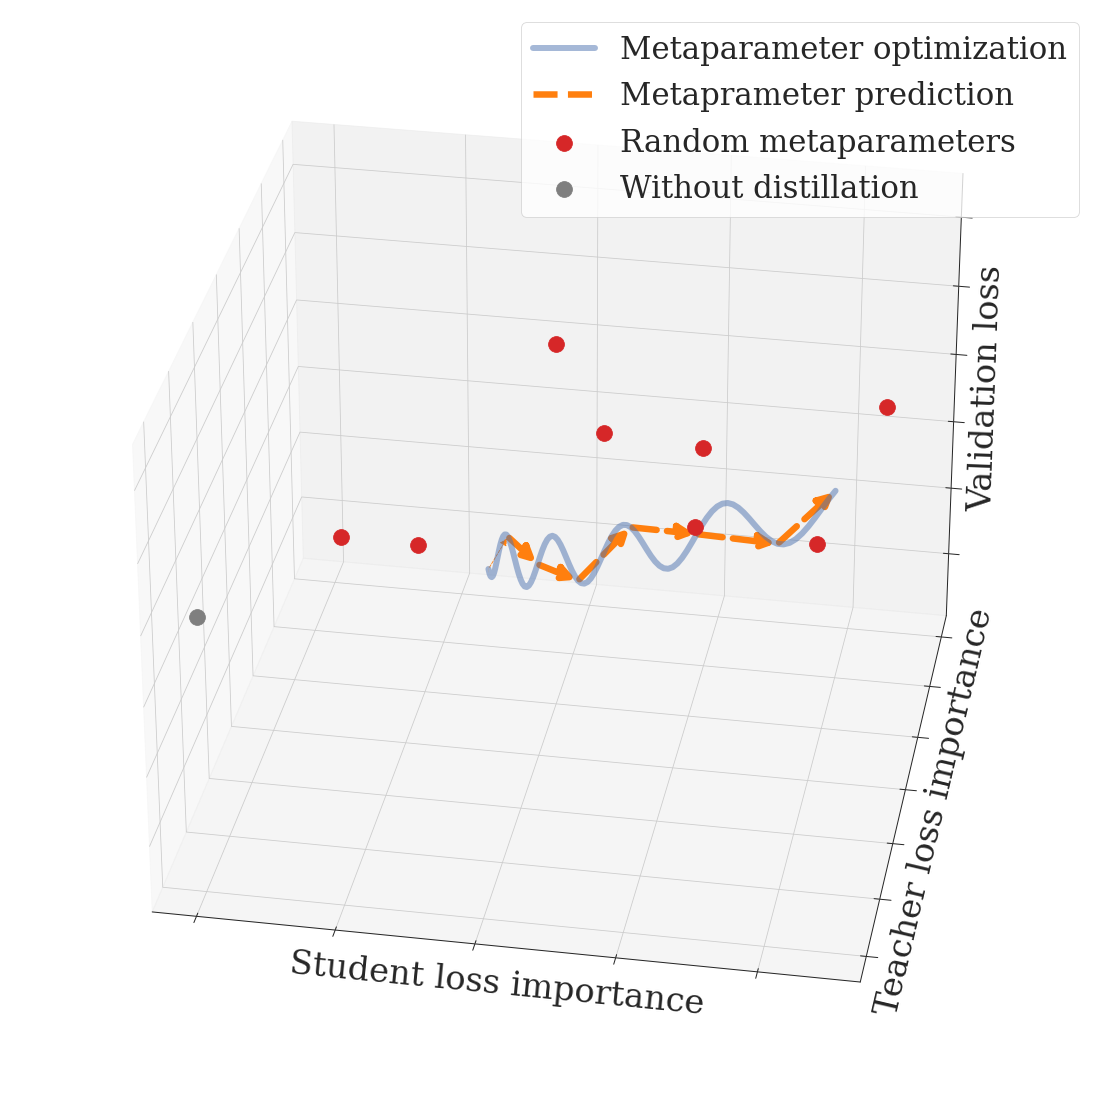

In [9]:
# %matplotlib notebook
# plt.rcParams['figure.figsize']=(8,8)
# plt.rcParams['lines.linewidth'] = 2

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(par1[0], par2[0], val[0], color='black', marker='o')
ax.plot3D(par1, par2, np.array(val) * 1.5, linewidth=6, label='Metaparameter optimization', alpha=0.5)
ax.plot3D([par1_[0], par1_[0]+0.0001], [par2_[0], par2_[0]+0.0001], 
          [val_[0], val_[0]+0.0001], linewidth=6.5, 
          label='Metaprameter prediction', color='tab:orange', ls='--')

ax.scatter3D(2*0.3, 1.5*(0.7-0.3), 1.07, color='tab:red', s=250)
ax.scatter3D(2*0.2, 1.5*(0.65-0.3), 0.7, color='tab:red', s=250)
ax.scatter3D(2*0.1, 1.5*(0.75-0.3), 0.67, color='tab:red', s=250)
ax.scatter3D(2*0.18, 1.5*(0.8-0.3), 0.8, color='tab:red', s=250)
ax.scatter3D(2*0.37, 1.5*(0.85-0.3), 0.79, color='tab:red', s=250)
ax.scatter3D(2*0.42, 1.5*(0.87-0.3), 0.84, color='tab:red', s=250)
ax.scatter3D(2*0.25, 1.5*(0.78-0.3), 1.0, color='tab:red', s=250)
ax.scatter3D(2*0.06, 1.5*(0.69-0.3), 0.95, color='tab:red', s=250, label='Random metaparameters')

ax.scatter3D(1, 1, .8, color='tab:grey', s=250, label='Without distillation')
#ax.scatter3D(1, 0, 1.25, color='tab:green', s=150, label='full distillation')

for i in range(len(par2_)-1):
    if i == 0:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=15, arrowstyle="-|>",
                   linestyle='dashed', 
                   ec='tab:orange', fc='tab:orange')
    else:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5, 
                   ec='tab:orange', fc='tab:orange')

ax.set_xlabel('Student loss importance')
ax.set_ylabel('Teacher loss importance')
ax.set_zlabel('Validation loss')
ax.legend(loc='best')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.view_init(30, 100)
# plt.savefig('../figs/trajectory.pdf')
plt.show()

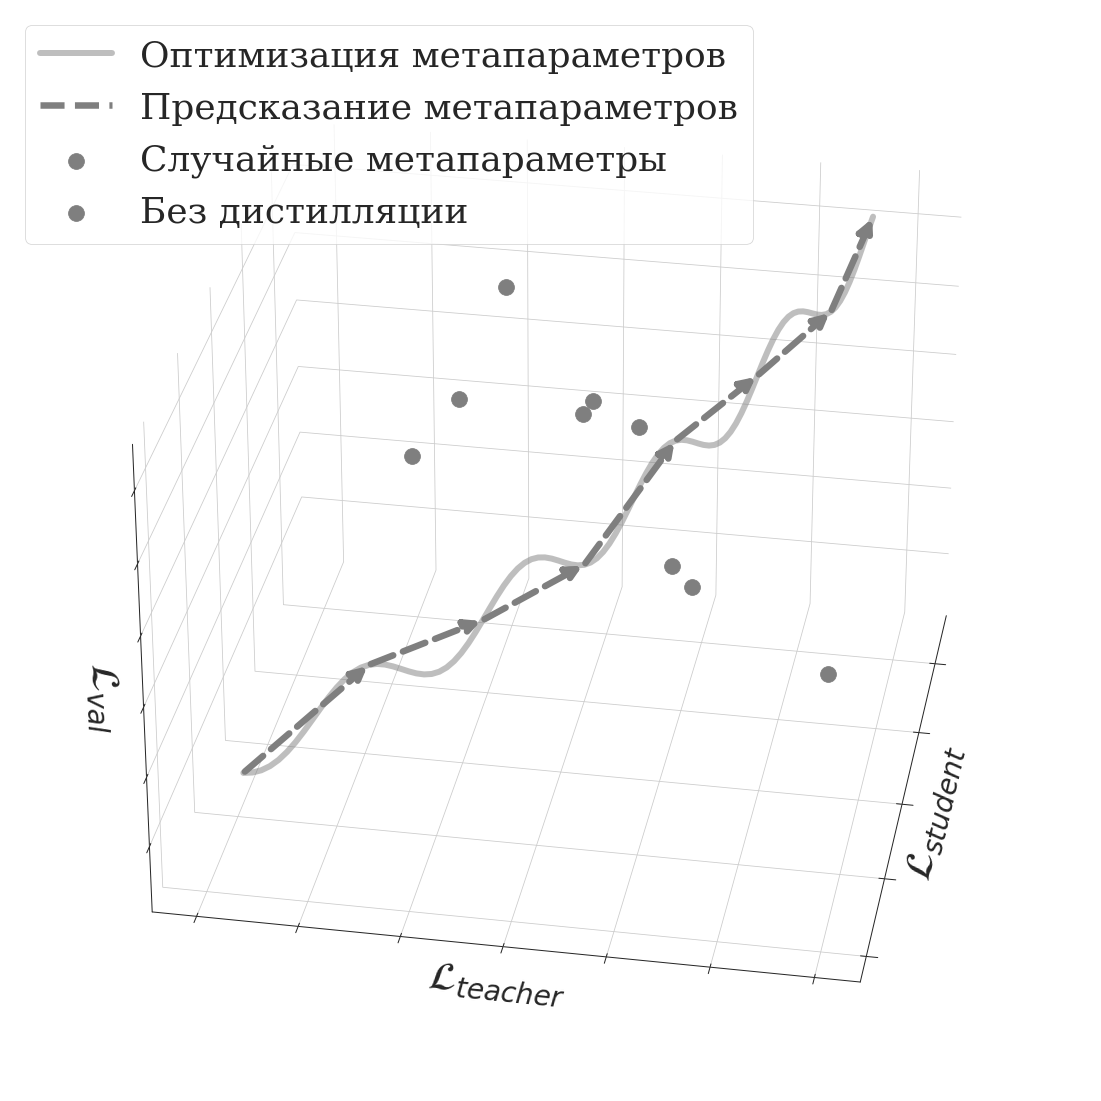

In [25]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40#22

# %matplotlib notebook
# plt.rcParams['figure.figsize']=(8,8)
# plt.rcParams['lines.linewidth'] = 2

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(par1[0], par2[0], val[0], color='black', marker='o')
ax.plot3D(par1, par2, np.array(val) * 1.5, linewidth=6, label='Оптимизация метапараметров', alpha=0.5 , color='tab:grey')
ax.plot3D([par1_[0], par1_[0]+0.0001], [par2_[0], par2_[0]+0.0001], 
          [val_[0], val_[0]+0.0001], linewidth=6.5, 
          label='Предсказание метапараметров', color='tab:grey', ls='--')

ax.scatter3D(2*0.3, 1.5*(0.7-0.3), 1.07, color='tab:grey', s=250)
ax.scatter3D(2*0.2, 1.5*(0.65-0.3), 0.7, color='tab:grey', s=250)
ax.scatter3D(2*0.1, 1.5*(0.75-0.3), 0.67, color='tab:grey', s=250)
ax.scatter3D(2*0.18, 1.5*(0.8-0.3), 0.8, color='tab:grey', s=250)
ax.scatter3D(2*0.37, 1.5*(0.85-0.3), 0.79, color='tab:grey', s=250)
ax.scatter3D(2*0.42, 1.5*(0.87-0.3), 0.84, color='tab:grey', s=250)
ax.scatter3D(2*0.25, 1.5*(0.78-0.3), 1.0, color='tab:grey', s=250)
ax.scatter3D(2*0.06, 1.5*(0.69-0.3), 0.95, color='tab:grey', s=250, label='Случайные метапараметры')

ax.scatter3D(1, 1, .8, color='tab:grey', s=250, label='Без дистилляции')
#ax.scatter3D(1, 0, 1.25, color='tab:green', s=150, label='full distillation')

for i in range(len(par2_)-1):
    if i == 0:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5,
                   ec='tab:grey', fc='tab:grey')
    else:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5, 
                   ec='tab:grey', fc='tab:grey')

ax.set_xlabel('$\mathcal{L}_{student}$')
ax.set_ylabel('$\mathcal{L}_{teacher}$')
ax.set_zlabel('$\mathcal{L}_{val}$')
ax.legend(loc='best')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.view_init(30, 10)
#ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#plt.savefig('../figs/trajectory_rus.pdf')
plt.show()

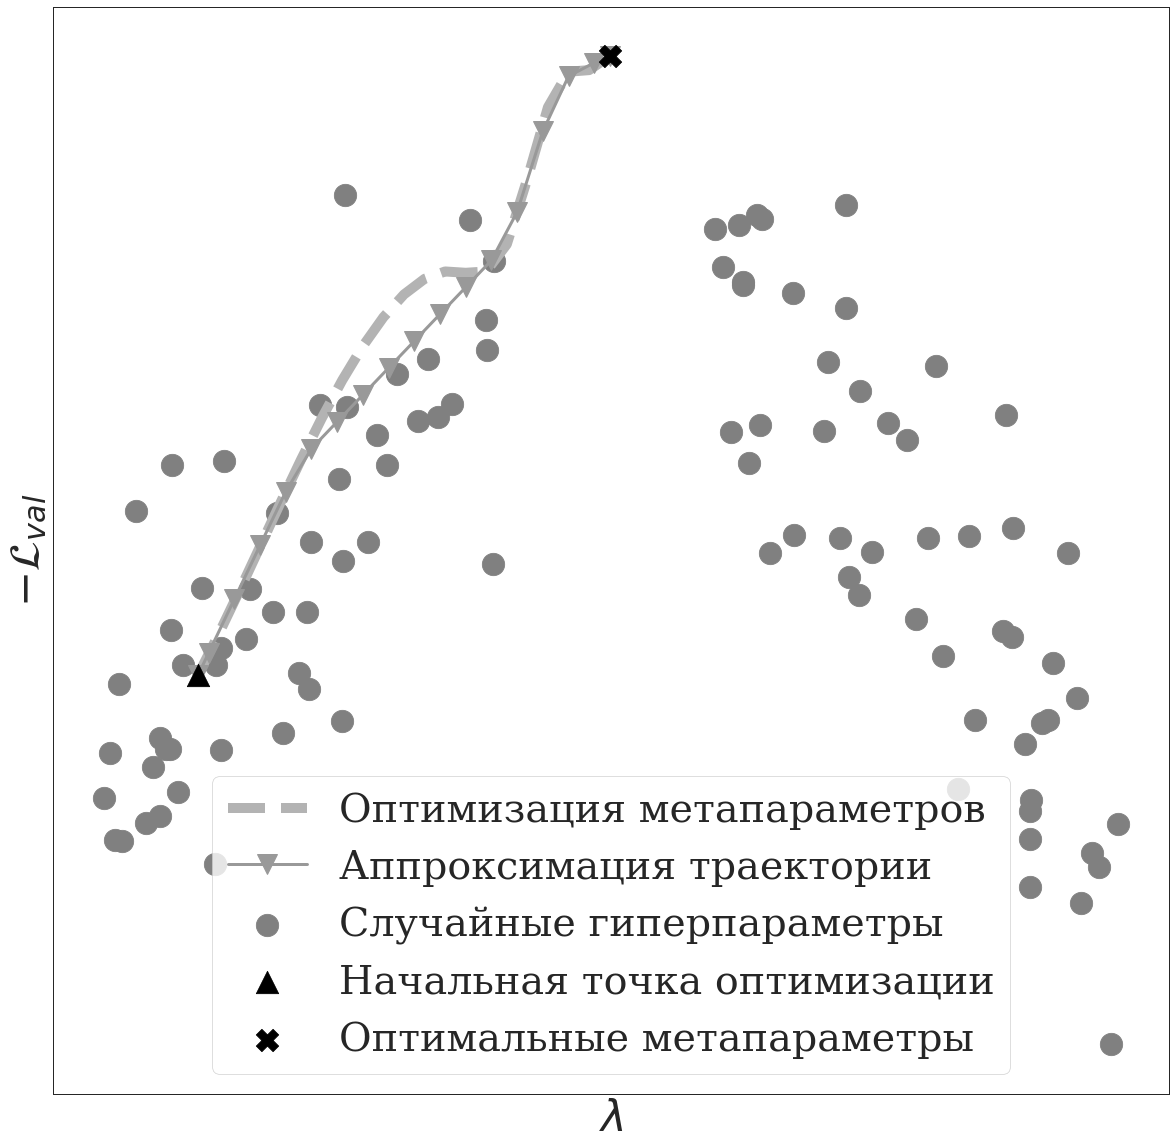

In [253]:
from scipy.ndimage.filters import gaussian_filter1d


rs = np.random.RandomState(42)
random_x = rs.uniform(size=50, low = 0.0, high=0.4)
random_x = np.hstack([random_x, rs.uniform(size=50, low = 0.6, high=1.0)])
random_y = -(random_x - 0.5)**2 + rs.randn(random_x.shape[0])*0.05


plt.scatter(random_x, random_y, label='Случайные гиперпараметры', s=500, color='gray')

opt_x = [0.5]
opt_y  = [0.08]



init_x = [0.1]
init_y = [-0.15]

hyper_x = [0.1, 0.2,  0.35, 0.4, 0.45, 0.47, 0.5]
hyper_y = [-0.15, -0.07, -0.0, 0.01, 0.07, 0.075,  0.08]

f_cubic = interp1d(hyper_x, hyper_y, kind=3, fill_value="extrapolate")
#power_smooth = spline(, power, xnew)
new_hyper_x = np.arange(0.1, 0.51, 0.02)
new_hyper_y = f_cubic(new_hyper_x)




#plt.plot(hyper_x, hyper_y)
plt.plot(new_hyper_x, new_hyper_y, lw=10, ls='--', color=(0.7,0.7,0.7), 
         label='Оптимизация метапараметров')

lin_x = [0.1, 0.2,   0.4, 0.45, 0.47, 0.5]
lin_y = [-0.15, -0.07, 0.01, 0.07, 0.075,  0.08]

lin_x2 = np.arange(lin_x[0]+0.01, lin_x[-1]-0.01, 0.025)
lin_y2 = []
for x in lin_x2:
    left = [i for i in range(len(lin_x)) if x>=lin_x[i]][-1]
    right = [i for i in range(len(lin_x))  if x<=lin_x[i]][0]
    
    
    part = (x - lin_x[left])/(lin_x[right] - lin_x[left])
    lin_y2.append(part * lin_y[right] + (1-part)*lin_y[left])
lin_x2 = [lin_x[0]] + lin_x2.tolist() + [lin_x[-1]]
lin_y2 = [lin_y[0]] + lin_y2 + [lin_y[-1]]
plt.plot(lin_x2 , np.array(lin_y2), label='Аппроксимация траектории', 
         color=(0.6,0.6,0.6),
         lw=3, markersize=20, marker='v')


plt.scatter(init_x, init_y, color='black', label='Начальная точка оптимизации', marker='^',  s=500,zorder=10)
plt.scatter(opt_x, opt_y, color='black', label='Оптимальные метапараметры', marker='X',  s=500,zorder=10)


plt.legend(loc='best')
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('$-\mathcal{L}_{val}$')
plt.xlabel('$\lambda$')
plt.savefig('../figs/trajectory_rus.pdf')

In [193]:
len(lin_y2)

40